In [14]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision.datasets import ImageFolder
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
from collections import Counter
import torch
from sklearn.metrics import f1_score, accuracy_score

In [15]:
pokemon_index_dict = {
    "Bug":0,
    "Dark":1,
    "Dragon":2,
    "Electric":3,
    "Fairy":4,
    "Fighting":5,
    "Fire":6,
    "Flying":7,
    "Ghost":8,
    "Grass":9,
    "Ground":10,
    "Ice":11,
    "Normal":12,
    "Poison":13,
    "Psychic":14,
    "Rock":15,
    "Steel":16,
    "Water":17
}

In [16]:
pokemon_type_list = [
    "Bug",
    "Dark",
    "Dragon",
    "Electric",
    "Fairy",
    "Fighting",
    "Fire",
    "Flying",
    "Ghost",
    "Grass",
    "Ground",
    "Ice",
    "Normal",
    "Poison",
    "Psychic",
    "Rock",
    "Steel",
    "Water"
]

In [17]:
# User input for image resolution
px = 300 # efficientNet works better with high resolution
img_size = (px,px)

#Batch Size
batch_size = 25

#GPU to run on
current_device='cuda:5'

# Set the path to the dataset directories
image_directory = 'archive/additional_images'
path_to_type_csv = 'archive/pokemon_with_folders.csv'

In [18]:
pokemon_type_dataset = pd.read_csv(path_to_type_csv)

def get_pokemon_types(pokemon_name):
    row = pokemon_type_dataset.loc[pokemon_type_dataset.index[pokemon_type_dataset['Name'].apply(str.lower) == pokemon_name.strip().replace(" ", "").lower()]]
    if len(row) > 0:
        t1 = row["Type"].values
        t2 = row["Other Type"].values
        types = []
        types.append(t1[0])
        if type(t2[0]) != float:
            types.append(t2[0])

        type_binary = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

        for poke_type in types:
            if pokemon_index_dict.__contains__(poke_type):
                type_binary[pokemon_index_dict.get(poke_type)] = 1

        return type_binary
    return None

In [19]:
class ImageFolderWithTypes(Dataset):
    """
    Wraps a torchvision ImageFolder and converts folder-class names to an 18-d
    multi-hot label using the existing `get_pokemon_types(name)` helper.
    - imagefolder: an instance of torchvision.datasets.ImageFolder
    - get_type_fn: function that accepts a pokemon name and returns a list/array of 18 ints or None
    - normalize_name_fn: function to normalize folder names (default replaces '_' with ' ')
    """

    def __init__(self, imagefolder: ImageFolder, get_type_fn=get_pokemon_types, normalize_name_fn=lambda s: s.replace('_', ' ')):
        self.imagefolder = imagefolder
        self.get_type_fn = get_type_fn
        self.normalize = normalize_name_fn

        # Build index of valid sample indices and labels
        self.indices = []
        self.labels = []  # list of lists (multi-hot)
        for i, (img_path, cls_idx) in enumerate(self.imagefolder.samples):
            cls_name = self.imagefolder.classes[cls_idx]
            normalized = self.normalize(cls_name)
            types = self.get_type_fn(normalized)
            if types is None:
                # skip samples we can't map; you can log them for inspection
                # print(f"Skipping unmapped class: {cls_name}")
                continue
            self.indices.append(i)
            self.labels.append(np.array(types, dtype=np.float32))

        # compute class positive counts (useful for pos_weight)
        self.labels_np = np.vstack(self.labels) if len(self.labels) > 0 else np.zeros((0, len(pokemon_type_list)), dtype=np.float32)
        self.pos_counts = self.labels_np.sum(axis=0) if self.labels_np.size else np.zeros(len(pokemon_type_list))
        self.neg_counts = len(self.labels) - self.pos_counts

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        orig_idx = self.indices[idx]
        image, _ = self.imagefolder[orig_idx]  # will apply transforms
        label = torch.from_numpy(self.labels[idx])  # float tensor for BCEWithLogitsLoss
        return image, label

    def get_pos_weight_tensor(self, device=None):
        # Avoid division by zero
        eps = 1e-6
        pos = self.pos_counts
        neg = self.neg_counts
        pos_weight = (neg + eps) / (pos + eps)
        t = torch.tensor(pos_weight, dtype=torch.float32)
        if device:
            return t.to(device)
        return t

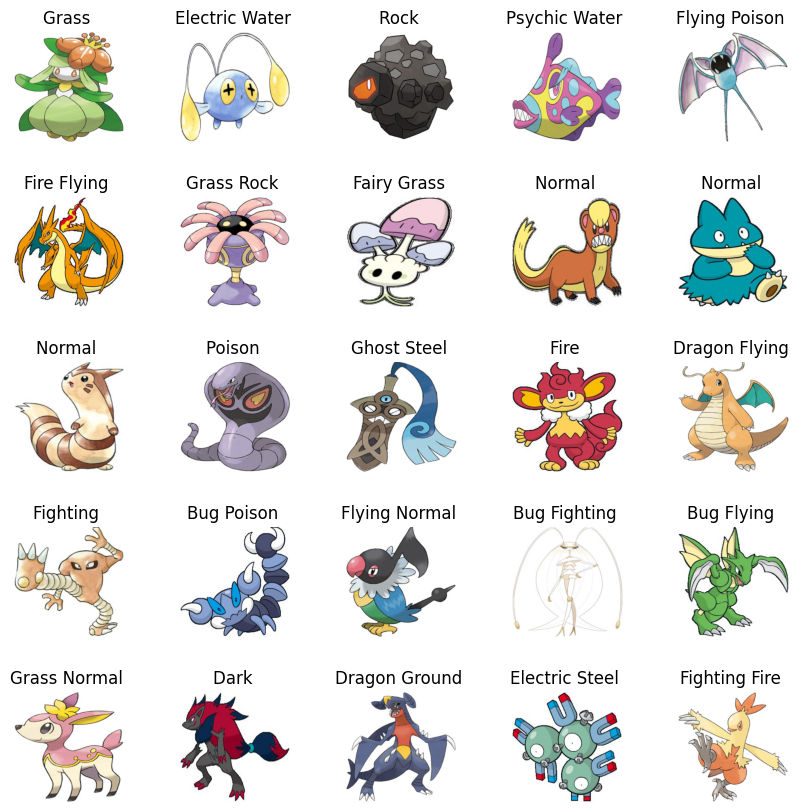

In [20]:
# Visualize data 
# Define function that plots multiple images in an array of images
def PlotImages(ix_start,num_img,rows,cols,images,labels,color=True):
    plt.figure(figsize=(10,10))
    plt.subplots_adjust(wspace=0.5,hspace=0.5)
    for i in range(num_img):
        plt.subplot(rows,cols,i+1)
        plt.axis('off')
        if color:
            plt.imshow(images.permute(0, 2, 3, 1)[ix_start+i])
        else: 
            plt.imshow(np.squeeze(images[ix_start+i]),cmap='Greys')
        pokemon_types = labels[ix_start+i]
        
        title = ""
        for index in range(0, 18):
            if pokemon_types[index] == 1:
                title = title + pokemon_type_list[index] + " "

        plt.title(title)

# Image loader and scaler for image exploration
explorer_batch_size = 25
load_image = transforms.Compose([
    transforms.Resize((px, px)),
    transforms.ToTensor()
])
raw_folder = ImageFolder(root=image_directory, transform=load_image)
dataset = ImageFolderWithTypes(raw_folder)
dataloader = DataLoader(dataset, batch_size=explorer_batch_size, shuffle=True, num_workers=47)
data_iter = iter(dataloader)

images, labels = next(data_iter)
next(data_iter)
PlotImages(0,explorer_batch_size,5,5,images,labels,color=True)

In [21]:
# =============================================================================
# Function to create weighted sampler for handling class imbalance
# =============================================================================
def create_weighted_sampler(dataset):
    """
    Create a WeightedRandomSampler for a multilabel dataset.

    The dataset is expected to return (image, label) where label is a 1-D
    binary array/tensor of length C (multi-hot). We compute per-class
    inverse-frequency weights and give each sample a weight equal to the
    sum of weights of the classes present in that sample (plus a small
    constant to avoid zero weight).
    """
    # Collect labels as numpy arrays (N x C)
    labels = []
    for i in range(len(dataset)):
        lab = dataset[i][1]
        if isinstance(lab, torch.Tensor):
            lab = lab.detach().cpu().numpy()
        labels.append(np.array(lab, dtype=np.float32))
    if len(labels) == 0:
        raise ValueError("Dataset contains no mapped samples")

    labels_np = np.vstack(labels)  # shape (N, C)
    N, C = labels_np.shape

    # Per-class positive counts
    pos_counts = labels_np.sum(axis=0)  # length C
    # Avoid division by zero
    eps = 1e-6
    # Inverse frequency weight for each class: more weight for rarer classes
    class_weights = (N - pos_counts + eps) / (pos_counts + eps)

    # Per-sample weight: sum of the class weights for classes present in sample
    sample_weights = (labels_np * class_weights).sum(axis=1) + 1e-3

    # Normalize optional (keep relative weights)
    sample_weights = sample_weights / (sample_weights.sum() / N)

    sampler = WeightedRandomSampler(weights=sample_weights.tolist(), num_samples=N, replacement=True)
    return sampler

In [22]:
# =============================================================================
# Function to calculate per-class pos_weight for BCEWithLogitsLoss (multilabel)
# =============================================================================
def calculate_pos_weight_from_multilabel(labels_list):
    """
    Given a list (or array) of multi-hot label vectors (N x C), compute the
    pos_weight tensor recommended for torch.nn.BCEWithLogitsLoss.

    labels_list: iterable of length-N where each element is length-C (list/np/torch)
    returns: torch.FloatTensor of length C usable as pos_weight
    """
    if len(labels_list) == 0:
        return torch.ones(len(pokemon_type_list), dtype=torch.float32)

    # Ensure a numpy array (N, C)
    if isinstance(labels_list, np.ndarray):
        labels_np = labels_list.astype(np.float32)
    else:
        labels_np = np.vstack([np.array(x, dtype=np.float32) for x in labels_list])

    N, C = labels_np.shape
    pos_counts = labels_np.sum(axis=0)
    neg_counts = N - pos_counts

    # pos_weight = neg/pos for each class; avoid divide-by-zero
    eps = 1e-6
    pos_weight = (neg_counts + eps) / (pos_counts + eps)

    # Convert to torch tensor
    return torch.tensor(pos_weight, dtype=torch.float32)


In [23]:
# =============================================================================
# IMPROVED: Train full network end-to-end instead of just features
# =============================================================================

# Impot necessary libraries
from time import time
from sklearn.model_selection import train_test_split

# Load full dataset and split into train/test
raw_folder = ImageFolder(root=image_directory)
full_dataset = ImageFolderWithTypes(raw_folder)
all_labels = [full_dataset[i][1] for i in range(len(full_dataset))]

# Split indices with stratification to maintain class distribution
train_indices, test_indices = train_test_split(
    range(len(full_dataset)), 
    test_size=0.2, 
    random_state=0
)

print(f'Train size: {len(train_indices)}, Test size: {len(test_indices)}')


Train size: 2000, Test size: 501


In [24]:

# This class encapsulates all the data loading and preparation steps.
class PokemonDataModule(pl.LightningDataModule):
    def __init__(self, dataset, train_indices, test_indices, batch_size=64):
        super().__init__()
        self.dataset = dataset
        self.train_indices = train_indices
        self.test_indices = test_indices
        self.batch_size = batch_size
        
        # Define transforms with augmentation for training
        self.train_transform = transforms.Compose([
            transforms.Resize((px + 20, px + 20)),
            transforms.RandomCrop((px, px)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        self.test_transform = transforms.Compose([
            transforms.Resize((px, px)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
    def setup(self, stage=None):
        # Create train and test datasets with appropriate transforms
        raw_folder1 = ImageFolder(root=image_directory, transform=self.train_transform)
        self.train_dataset = ImageFolderWithTypes(raw_folder1)

        raw_folder2 = ImageFolder(root=image_directory, transform=self.test_transform)
        self.test_dataset = ImageFolderWithTypes(raw_folder2)
        
        # Use subset of indices for train/test split
        self.train_subset = torch.utils.data.Subset(self.train_dataset, self.train_indices)
        self.test_subset = torch.utils.data.Subset(self.test_dataset, self.test_indices)
        
    def train_dataloader(self):
        # Create a multilabel-aware weighted sampler for the training subset
        # The helper `create_weighted_sampler` expects a dataset returning
        # (image, multi_hot_label) and will compute per-sample weights.
        sampler = create_weighted_sampler(self.train_subset)
        return DataLoader(self.train_subset, batch_size=self.batch_size, sampler=sampler, num_workers=47)
    
    def test_dataloader(self):
        return DataLoader(self.test_subset, batch_size=self.batch_size, shuffle=False, num_workers=47)



In [25]:

# =============================================================================
# IMPROVED MODEL: Fine-tune VGG16 instead of frozen features
# =============================================================================

class EfficientNetB3PokemonClassifier(pl.LightningModule):
    def __init__(self, num_classes=len(pokemon_type_list), learning_rate=0.001):
        super().__init__()
        self.learning_rate = learning_rate
        self.test_step_outputs = []

        efficientnet = models.efficientnet_b3(weights='EfficientNet_B3_Weights.DEFAULT')
        
        # EfficientNet uses 'features' (convolution layers) and 'classifier' (final layer)
        # Freeze early layers (first 4 out of 9 blocks)
        for i, block in enumerate(efficientnet.features):
            if i < 4:  # Freeze first 4 blocks
                for param in block.parameters():
                    param.requires_grad = False
            else:  # Unfreeze later blocks
                for param in block.parameters():
                    param.requires_grad = True

        self.features = efficientnet.features
        
        # Add adaptive pooling to get fixed-size output
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),  # EfficientNet typically uses less dropout
            nn.Linear(1536, 512),  # 1536 is EfficientNet-B3's feature dimension
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes),
        )

        # pos_weight for BCEWithLogitsLoss
        train_labels_tensor = torch.stack([torch.tensor(all_labels[i]) for i in train_indices])
        pos_weight = (len(train_indices) - train_labels_tensor.sum(0)) / (train_labels_tensor.sum(0) + 1e-6)
        self.register_buffer('pos_weight', pos_weight)
        self.criterion = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)

        self.best_acc = 0

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)  # Flatten from (batch, 1536, 1, 1) to (batch, 1536)
        return self.classifier(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        labels = labels.type_as(outputs)
        loss = self.criterion(outputs, labels)

        preds = (torch.sigmoid(outputs) > 0.5).float()
        acc = (preds == labels).float().mean()

        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        labels = labels.type_as(outputs)
        loss = self.criterion(outputs, labels)

        preds = (torch.sigmoid(outputs) > 0.5).float()
        self.test_step_outputs.append({
            'preds': preds.detach().cpu(),
            'labels': labels.detach().cpu()
        })
        acc = (preds == labels).float().mean() 
        
        self.log('test_loss', loss, prog_bar=True) 
        self.log('test_acc', acc, prog_bar=True) 

        return {'test_loss': loss, 'test_acc': acc}

    def on_test_epoch_end(self):
        if not self.test_step_outputs:
            return

        all_preds = torch.cat([x['preds'] for x in self.test_step_outputs], dim=0).numpy()
        all_labels = torch.cat([x['labels'] for x in self.test_step_outputs], dim=0).numpy()

        per_class_acc = (all_preds == all_labels).mean(axis=0)
        per_class_f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)

        print("\nPer-class Accuracy & F1:")
        for i, poke_type in enumerate(pokemon_type_list):
            print(f"{poke_type:10}: Acc {per_class_acc[i]:.3f}, F1 {per_class_f1[i]:.3f}")

        macro_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        micro_f1 = f1_score(all_labels, all_preds, average='micro', zero_division=0)
        print(f"\nMacro F1: {macro_f1:.3f}, Micro F1: {micro_f1:.3f}")

        self.test_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam([
            {'params': self.features.parameters(), 'lr': self.learning_rate * 0.1},
            {'params': self.classifier.parameters(), 'lr': self.learning_rate}
        ], weight_decay=1e-4)

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.5, patience=5
        )

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'train_acc',
                'interval': 'epoch',
                'reduce_on_plateau': True,
                'verbose': True
            }
        }

In [26]:

# Instantiate the DataModule
pokemon_data = PokemonDataModule(full_dataset, train_indices, test_indices, batch_size=batch_size)
pokemon_data.setup()

# Calculate and print class weights
train_labels = [all_labels[i] for i in train_indices]
pos_weight = calculate_pos_weight_from_multilabel(train_labels)
print("\nPer-class pos_weight for BCEWithLogitsLoss:")
for i, weight in enumerate(pos_weight.tolist()):
    print(f"  {pokemon_type_list[i]}: {weight:.4f}")

# Instantiate the improved model
model = EfficientNetB3PokemonClassifier(learning_rate=0.001)

# The Trainer with callbacks for better monitoring
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_callback = ModelCheckpoint(
    monitor='train_acc',
    dirpath='checkpoints2/',
    filename='pokemon-efficientnet-{epoch:02d}-{train_acc:.2f}',
    save_top_k=3,
    mode='max'
)

early_stop_callback = EarlyStopping(
    monitor='train_acc',
    patience=15,
    mode='max',
    verbose=True
)

trainer = pl.Trainer(
    max_epochs=20,
    accelerator='gpu',
    devices=[4],
    callbacks=[checkpoint_callback, early_stop_callback],
    log_every_n_steps=10
)

# Start the training process
time_start = time()
trainer.fit(model, datamodule=pokemon_data)
time_stop = time()

print(f"\nElapsed training time: {round(time_stop - time_start, 1)} sec.")
print(f"Best training accuracy achieved: {model.best_acc:.2f}%")

# Evaluate the model on the test dataset
test_results = trainer.test(model, datamodule=pokemon_data)
print(f"\nFinal test results: {test_results}")

/tmp/ipykernel_2743530/2804406287.py:19: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  labels_np = np.vstack([np.array(x, dtype=np.float32) for x in labels_list])



Per-class pos_weight for BCEWithLogitsLoss:
  Bug: 9.8696
  Dark: 17.0180
  Dragon: 15.5289
  Electric: 15.2602
  Fairy: 15.5289
  Fighting: 15.0000
  Fire: 11.1212
  Flying: 6.9365
  Ghost: 17.6916
  Grass: 7.9686
  Ground: 11.6582
  Ice: 25.6667
  Normal: 6.4627
  Poison: 10.4286
  Psychic: 8.6618
  Rock: 13.2857
  Steel: 16.5439
  Water: 5.1538


/tmp/ipykernel_2743530/3351815777.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.stack([torch.tensor(all_labels[i]) for i in train_indices])
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/work/envs/venv/DL_gpu/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /work/cssema416/202610/08/checkpoints2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/work/envs/venv/DL_gpu/lib/python3.11/site-packages/pytorch_lightning/core/optimizer.py:259: Found unsupported keys in the lr scheduler dict: {'verbose'}. HINT: remove them from the output of `configure_optimizers`.

  | Name       | Type              | Params | Mode 
------------------------------------------

Epoch 0: 100%|██████████| 80/80 [00:20<00:00,  3.86it/s, v_num=56, train_loss=1.040, train_acc=0.704]

Metric train_acc improved. New best score: 0.704


Epoch 1: 100%|██████████| 80/80 [00:22<00:00,  3.53it/s, v_num=56, train_loss=0.683, train_acc=0.813]

Metric train_acc improved by 0.109 >= min_delta = 0.0. New best score: 0.813


Epoch 2: 100%|██████████| 80/80 [00:22<00:00,  3.55it/s, v_num=56, train_loss=0.476, train_acc=0.900]

Metric train_acc improved by 0.087 >= min_delta = 0.0. New best score: 0.900


Epoch 3: 100%|██████████| 80/80 [00:22<00:00,  3.55it/s, v_num=56, train_loss=0.378, train_acc=0.927]

Metric train_acc improved by 0.027 >= min_delta = 0.0. New best score: 0.927


Epoch 4: 100%|██████████| 80/80 [00:22<00:00,  3.57it/s, v_num=56, train_loss=0.301, train_acc=0.931]

Metric train_acc improved by 0.004 >= min_delta = 0.0. New best score: 0.931


Epoch 5: 100%|██████████| 80/80 [00:22<00:00,  3.56it/s, v_num=56, train_loss=0.214, train_acc=0.951]

Metric train_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.951


Epoch 6: 100%|██████████| 80/80 [00:22<00:00,  3.53it/s, v_num=56, train_loss=0.156, train_acc=0.967]

Metric train_acc improved by 0.016 >= min_delta = 0.0. New best score: 0.967


Epoch 7: 100%|██████████| 80/80 [00:22<00:00,  3.50it/s, v_num=56, train_loss=0.132, train_acc=0.971] 

Metric train_acc improved by 0.004 >= min_delta = 0.0. New best score: 0.971


Epoch 9: 100%|██████████| 80/80 [00:22<00:00,  3.55it/s, v_num=56, train_loss=0.100, train_acc=0.978] 

Metric train_acc improved by 0.007 >= min_delta = 0.0. New best score: 0.978


Epoch 10: 100%|██████████| 80/80 [00:22<00:00,  3.56it/s, v_num=56, train_loss=0.0628, train_acc=0.984]

Metric train_acc improved by 0.007 >= min_delta = 0.0. New best score: 0.984


Epoch 13: 100%|██████████| 80/80 [00:22<00:00,  3.55it/s, v_num=56, train_loss=0.0422, train_acc=0.991]

Metric train_acc improved by 0.007 >= min_delta = 0.0. New best score: 0.991


Epoch 18: 100%|██████████| 80/80 [00:22<00:00,  3.57it/s, v_num=56, train_loss=0.0518, train_acc=0.996]

Metric train_acc improved by 0.004 >= min_delta = 0.0. New best score: 0.996


Epoch 19: 100%|██████████| 80/80 [00:22<00:00,  3.56it/s, v_num=56, train_loss=0.0529, train_acc=0.987]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 80/80 [00:22<00:00,  3.55it/s, v_num=56, train_loss=0.0529, train_acc=0.987]

Elapsed training time: 503.2 sec.
Best training accuracy achieved: 0.00%


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 0: 100%|██████████| 21/21 [00:02<00:00,  9.61it/s]
Per-class Accuracy & F1:
Bug       : Acc 0.948, F1 0.711
Dark      : Acc 0.960, F1 0.600
Dragon    : Acc 0.956, F1 0.633
Electric  : Acc 0.980, F1 0.857
Fairy     : Acc 0.964, F1 0.719
Fighting  : Acc 0.962, F1 0.698
Fire      : Acc 0.962, F1 0.796
Flying    : Acc 0.940, F1 0.769
Ghost     : Acc 0.964, F1 0.667
Grass     : Acc 0.960, F1 0.848
Ground    : Acc 0.926, F1 0.673
Ice       : Acc 0.962, F1 0.612
Normal    : Acc 0.898, F1 0.691
Poison    : Acc 0.968, F1 0.843
Psychic   : Acc 0.904, F1 0.593
Rock      : Acc 0.956, F1 0.738
Steel     : Acc 0.968, F1 0.765
Water     : Acc 0.924, F1 0.759

Macro F1: 0.721, Micro F1: 0.730
Testing DataLoader 0: 100%|██████████| 21/21 [00:02<00:00,  9.34it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────